# CS221 Project
**Dawn Finzi and Mona Rosenke 11/15/2018**

In [1]:
#This notebook contains some initial explorations into fitting a CNN for the dermoscopy data

#Initial setup partially derived from https://www.kaggle.com/yassineghouzam/introduction-to-cnn-keras-0-997-top-6
#Also requires the keras implementation of resnet found at https://github.com/raghakot/keras-resnet

In [2]:
#Import a bunch of required packages
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from glob import glob
import seaborn as sns
from PIL import Image
np.random.seed(12345)

from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
import itertools

import keras
from keras.utils.np_utils import to_categorical # used for converting labels to one-hot-encoding
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras import backend as K
from keras.layers.normalization import BatchNormalization
from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
from keras.callbacks import ReduceLROnPlateau, CSVLogger, EarlyStopping
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator

Using TensorFlow backend.


In [41]:
#Helper functions for later

#Plot the model training history (accuracy and loss)
def plot_model_history(model_history):
    plt.style.use('seaborn')
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    # summarize history for accuracy
    axs[0].plot(range(1,len(model_history.history['acc'])+1),model_history.history['acc'])
    axs[0].plot(range(1,len(model_history.history['val_acc'])+1),model_history.history['val_acc'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_history.history['acc'])+1),len(model_history.history['acc'])/10)
    axs[0].legend(['train', 'val'], loc='best')
    # summarize history for loss
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()

#To clean up confusion matriz 
def round_sig(f, p):
    return float(('%.' + str(p) + 'e') % f)

#Plot confusion matrix - normalizes by category based on the true labels
def plot_confusion_matrix(cm, classes,
                          normalize=True,
                          title='Confusion matrix',
                          cmap=plt.cm.viridis):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.style.use('default')
    
    if normalize: 
        #normalize by true class b/c they vary greatly in num images
        cm = cm.astype('float')
        class_totals = cm.sum(axis=1)
        for i in range(len(classes)):
            for j in range(len(classes)):
                cm[i,j] = cm[i,j] /class_totals[i]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, round_sig(cm[i, j],2),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('Actual')
    plt.xlabel('Predicted')    

In [4]:
#Import the image data from the two folders
base_skin_dir = os.path.join('..', 'data')

imageid_path_dict = {os.path.splitext(os.path.basename(x))[0]: x
                     for x in glob(os.path.join(base_skin_dir, '*', '*.jpg'))}

lesion_type_dict = {
    'nv': 'Melanocytic nevi',
    'mel': 'Melanoma',
    'bkl': 'Benign keratosis-like lesions ',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'
}

In [5]:
#Read in the metadata

meta = pd.read_csv(os.path.join(base_skin_dir, 'HAM10000_metadata.csv'))

meta['path'] = meta['image_id'].map(imageid_path_dict.get)
meta['cell_type'] = meta['dx'].map(lesion_type_dict.get) 
meta['cell_type_idx'] = pd.Categorical(meta['cell_type']).codes
meta.sample(5)

,lesion_id,image_id,dx,dx_type,age,sex,localization,path,cell_type,cell_type_idx
3349,HAM_0007142,ISIC_0025255,nv,follow_up,50.0,female,lower extremity,../data/HAM10000_images/ISIC_0025255.jpg,Melanocytic nevi,4
7961,HAM_0002417,ISIC_0033442,nv,histo,NaN,male,upper extremity,../data/HAM10000_images/ISIC_0033442.jpg,Melanocytic nevi,4
5029,HAM_0005923,ISIC_0031419,nv,follow_up,55.0,female,lower extremity,../data/HAM10000_images/ISIC_0031419.jpg,Melanocytic nevi,4
2095,HAM_0002609,ISIC_0029318,mel,histo,60.0,female,back,../data/HAM10000_images/ISIC_0029318.jpg,Melanoma,5
8108,HAM_0000861,ISIC_0028734,nv,histo,20.0,female,lower extremity,../data/HAM10000_images/ISIC_0028734.jpg,Melanocytic nevi,4


In [6]:
#Load in all of the images into memory - this will take a while.  
#Resize step because the original dimensions of 450 * 600 * 3 was too much for TensorFlow
meta['image'] = meta['path'].map(lambda x: np.asarray(Image.open(x).resize((100,75))))

### Setup train, test and validation datasets

In [7]:
#Create x and y (drop labels from X and assign labels y)
X=meta.drop(columns=['cell_type_idx'],axis=1)
y=meta['cell_type_idx']

In [8]:
#Get train and test splits (80/20) - look into stratifying later!
x_train_o, x_test_o, y_train_o, y_test_o = train_test_split(X, y, test_size=0.20)

In [9]:
print x_train_o.shape
print x_test_o.shape

(8012, 10)
(2003, 10)


In [10]:
#Get the images from the list
x_train = np.asarray(x_train_o['image'].tolist())
x_test = np.asarray(x_test_o['image'].tolist())

In [11]:
#Subtract mean and normalize images (to reduce effect of illumination diffs)
x_train_mean = np.mean(x_train)
x_train_std = np.std(x_train)

x_test_mean = np.mean(x_test)
x_test_std = np.std(x_test)

x_train = (x_train - x_train_mean)/x_train_std
x_test = (x_test - x_test_mean)/x_test_std

In [12]:
#Convert class vectors to binary class matrices
y_train = to_categorical(y_train_o, num_classes = 7)
y_test = to_categorical(y_test_o, num_classes = 7)

In [13]:
#Split training data into training and validation subsets
x_train, x_validate, y_train, y_validate = train_test_split(x_train, y_train, test_size = 0.1)

In [14]:
# Reshape image in 3 dimensions (height = 28px, width = 28px , canal = 1)
x_train = x_train.reshape(x_train.shape[0], *(75, 100, 3))
x_test = x_test.reshape(x_test.shape[0], *(75, 100, 3))
x_validate = x_validate.reshape(x_validate.shape[0], *(75, 100, 3))

### CNN specific set up (inputs and parameters)

In [15]:
#Image dimensions
img_rows, img_cols = 75, 100
img_channels = 3 #RGB
input_shape = (img_rows, img_cols, img_channels)

batch_size = 16
nb_classes = 7
nb_epoch = 35

In [16]:
lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1), cooldown=0, patience=5, min_lr=0.5e-6) #learning rate annealer
early_stopper = EarlyStopping(min_delta=0.001, patience=10)

In [17]:
#Data augmentation to help with overfitting
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images

datagen.fit(x_train)

## Basic 3-layer network

In [18]:
#Set up 3 basic layers 
model = Sequential()

model.add(Conv2D(32, kernel_size=(3, 3),activation='relu',padding = 'Same',input_shape=input_shape))
model.add(Conv2D(32,kernel_size=(3, 3), activation='relu',padding = 'Same',))
model.add(MaxPool2D(pool_size = (2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu',padding = 'Same'))
model.add(Conv2D(64, (3, 3), activation='relu',padding = 'Same'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.40))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(nb_classes, activation='softmax'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 75, 100, 32)       896       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 75, 100, 32)       9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 37, 50, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 37, 50, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 37, 50, 64)        18496     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 37, 50, 64)        36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 18, 25, 64)        0         
__________

In [21]:
csv_logger = CSVLogger('basic_hmnist.csv') #save the info

#Compile the model - using categorical crossentropy loss and an Adam optimizer
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [22]:
#Fit the model
basic_history = model.fit_generator(datagen.flow(x_train,y_train, batch_size=batch_size),
                              epochs = nb_epoch, validation_data = (x_validate,y_validate),
                              verbose = 1, steps_per_epoch=x_train.shape[0] // batch_size
                              , callbacks=[lr_reducer, early_stopper, csv_logger])

Epoch 1/35
450/450 [==============================] - 124s 276ms/step - loss: 1.0298 - acc: 0.6620 - val_loss: 0.8836 - val_acc: 0.6658
Epoch 2/35
450/450 [==============================] - 124s 275ms/step - loss: 0.9056 - acc: 0.6741 - val_loss: 0.8472 - val_acc: 0.6783
Epoch 3/35
450/450 [==============================] - 120s 268ms/step - loss: 0.8707 - acc: 0.6825 - val_loss: 0.8204 - val_acc: 0.7007
Epoch 4/35
450/450 [==============================] - 117s 260ms/step - loss: 0.8520 - acc: 0.6894 - val_loss: 0.7679 - val_acc: 0.6995
Epoch 5/35
450/450 [==============================] - 118s 262ms/step - loss: 0.8232 - acc: 0.7001 - val_loss: 0.7580 - val_acc: 0.7007
Epoch 6/35
450/450 [==============================] - 118s 261ms/step - loss: 0.7983 - acc: 0.7025 - val_loss: 0.7621 - val_acc: 0.7257
Epoch 7/35
450/450 [==============================] - 123s 274ms/step - loss: 0.7827 - acc: 0.7166 - val_loss: 0.7280 - val_acc: 0.7319
Epoch 8/35
450/450 [============================

In [23]:
#Evaluate on test data
loss, accuracy = model.evaluate(x_test, y_test, verbose=1)
print("Test: accuracy = %f  ;  loss = %f" % (accuracy, loss))

2003/2003 [==============================] - 10s 5ms/step
Test: accuracy = 0.770844  ;  loss = 0.634516


In [24]:
#Check validation accuracy
loss, accuracy = model.evaluate(x_validate, y_validate, verbose=1)
print("Validation: accuracy = %f  ;  loss = %f" % (accuracy, loss))

802/802 [==============================] - 4s 5ms/step
Validation: accuracy = 0.763092  ;  loss = 0.623591


In [25]:
#Save model for later
model.save("basic_model.h5")

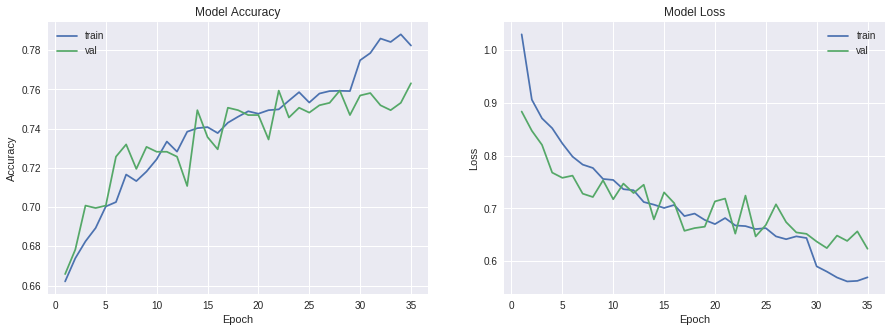

In [26]:
plot_model_history(basic_history)

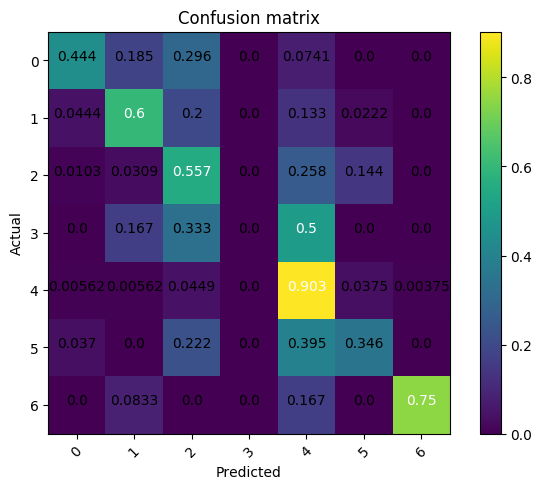

In [42]:
#Plot the confusion matrix
# Predict the values from the validation dataset
Y_pred = model.predict(x_validate)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
# Convert validation observations to one hot vectors
Y_true = np.argmax(y_validate,axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(7)) 

## Resnet 18

In [28]:
import resnet_k

csv_logger = CSVLogger('resnet18_hmnist.csv') #save the info
resnet_model = resnet_k.ResnetBuilder.build_resnet_18((img_channels, img_rows, img_cols), nb_classes) #load the architecture
# Compile the model - using categorical crossentropy loss and an Adam optimizer
resnet_model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [29]:
#Fit the model
resnet18_history = resnet_model.fit_generator(datagen.flow(x_train,y_train, batch_size=batch_size),
                              epochs = nb_epoch, validation_data = (x_validate,y_validate),
                              verbose = 1, steps_per_epoch=x_train.shape[0] // batch_size
                              , callbacks=[lr_reducer, early_stopper, csv_logger])

Epoch 1/35
450/450 [==============================] - 223s 497ms/step - loss: 1.5352 - acc: 0.6806 - val_loss: 1.3884 - val_acc: 0.6546
Epoch 2/35
450/450 [==============================] - 219s 487ms/step - loss: 1.1267 - acc: 0.6935 - val_loss: 1.1758 - val_acc: 0.6746
Epoch 3/35
450/450 [==============================] - 219s 488ms/step - loss: 1.0202 - acc: 0.6992 - val_loss: 0.9752 - val_acc: 0.7207
Epoch 4/35
450/450 [==============================] - 219s 488ms/step - loss: 0.9522 - acc: 0.7086 - val_loss: 1.1275 - val_acc: 0.7082
Epoch 5/35
450/450 [==============================] - 219s 488ms/step - loss: 0.9199 - acc: 0.7084 - val_loss: 0.8829 - val_acc: 0.7357
Epoch 6/35
450/450 [==============================] - 219s 488ms/step - loss: 0.8868 - acc: 0.7157 - val_loss: 1.3460 - val_acc: 0.6409
Epoch 7/35
450/450 [==============================] - 222s 494ms/step - loss: 0.8637 - acc: 0.7183 - val_loss: 0.9371 - val_acc: 0.6820
Epoch 8/35
450/450 [============================

In [30]:
#Evaluate on test data
loss, accuracy = resnet_model.evaluate(x_test, y_test, verbose=1)
print("Test: accuracy = %f  ;  loss = %f" % (accuracy, loss))

2003/2003 [==============================] - 19s 10ms/step
Test: accuracy = 0.778333  ;  loss = 0.658784


In [31]:
#Check validation accuracy
loss, accuracy = resnet_model.evaluate(x_validate, y_validate, verbose=1)
print("Validation: accuracy = %f  ;  loss = %f" % (accuracy, loss))

802/802 [==============================] - 8s 10ms/step
Validation: accuracy = 0.788030  ;  loss = 0.623325


In [32]:
#Save model for later
resnet_model.save("resnet18_model.h5")

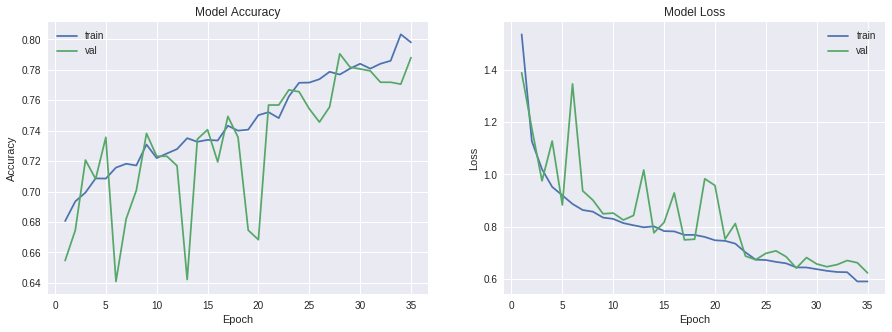

In [33]:
plot_model_history(resnet18_history)

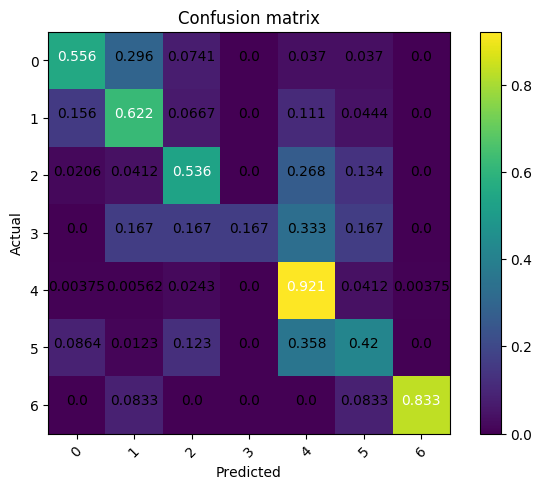

In [43]:
#Plot the confusion matrix
# Predict the values from the validation dataset
Y_pred = resnet_model.predict(x_validate)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
# Convert validation observations to one hot vectors
Y_true = np.argmax(y_validate,axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(7)) 

## Pretrained VGG16 network

In [44]:
from keras.applications.vgg16 import VGG16
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input
from keras.models import Sequential,Model,model_from_json

In [45]:
#Import and adapt the pretrained VGG16 model for our dataset
vgg16_model=VGG16(weights='imagenet',include_top=False,input_shape=(75,100,3))
#Set all the vgg16 layers as non-trainable
for l in vgg16_model.layers:
    l.trainable=False

In [46]:
csv_logger = CSVLogger('ptVGG16_hmnist.csv')

In [47]:
vgg16_model.output

<tf.Tensor 'block5_pool_1/MaxPool:0' shape=(?, 2, 3, 512) dtype=float32>

In [48]:
#Inspiration for custom layer setup comes from https://www.kaggle.com/arnabd2002/transferlearningwith-vgg16
#Add the custom layers after the last maxpool layer of vgg16
customLayers=Flatten()(vgg16_model.output)
customLayers=Dense(1000,activation='relu')(customLayers)
customLayers=Dropout(0.20)(customLayers)
customLayers=Dense(500,activation='relu')(customLayers)
customLayers=Dropout(0.20)(customLayers)
customLayers=Dense(nb_classes,activation='softmax')(customLayers)
customModel=Model(input=vgg16_model.input,output=customLayers)
customModel.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 75, 100, 3)        0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 75, 100, 64)       1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 75, 100, 64)       36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 37, 50, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 37, 50, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 37, 50, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 18, 25, 128)       0         
__________

/home/eshedm/.local/lib/python2.7/site-packages/ipykernel_launcher.py:9: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Tensor("de..., inputs=Tensor("in...)`
  if __name__ == '__main__':


In [49]:
#Define the optimizer (make learning rate smaller than default)
optimizer = Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)

In [50]:
customModel.compile(loss='categorical_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])

In [ ]:
VGG16_history = customModel.fit_generator(datagen.flow(x_train,y_train, batch_size=batch_size),
                              epochs = nb_epoch, validation_data = (x_validate,y_validate),
                              verbose = 1, steps_per_epoch=x_train.shape[0] // batch_size
                              , callbacks=[lr_reducer, early_stopper, csv_logger])

Epoch 1/35
 49/450 [==>...........................] - ETA: 3:15 - loss: 1.0139 - acc: 0.6888

In [ ]:
loss, accuracy = customModel.evaluate(x_test, y_test, verbose=1)
print("Test: accuracy = %f  ;  loss = %f" % (accuracy, loss))

In [ ]:
loss, accuracy = customModel.evaluate(x_validate, y_validate, verbose=1)
print("Validation: accuracy = %f  ;  loss = %f" % (accuracy, loss))

In [ ]:
plot_model_history(VGG16_history)

In [ ]:
#Plot the confusion matrix
# Predict the values from the validation dataset
Y_pred = customModel.predict(x_validate)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
# Convert validation observations to one hot vectors
Y_true = np.argmax(y_validate,axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(7)) 